# Train and Deploy a Deep Learning Model on AWS

In this notebook we use Sagemaker to finetune a pretrained model with hyperparameter tuning. Once the best hyperparameters have been found, we train an estimator using Sagemaker debugging and profiling. This model is then deployed and tested.

## Initial settings

In [1]:
import sagemaker
import boto3

from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    rule_configs,
    ProfilerConfig,
    FrameworkProfile
)

from sagemaker.debugger import CollectionConfig

In [2]:
session = sagemaker.Session()

bucket_sagemaker = session.default_bucket()
print("Default Bucket: {}".format(bucket_sagemaker))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

## Dataset
In this project we use the dog breed classication dataset to classify between different breeds of dogs in images.

#### Download and unzip data

In [3]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip # Slower
!aws s3 cp s3://udacity-aind/dog-project/dogImages.zip ./ # Much faster!

In [4]:
!unzip dogImages.zip

In [5]:
! ls  | grep dogImages

dogImages
dogImages.zip


How many images do we have?

In [7]:
! find dogImages/train -type f | wc -l

6680


In [8]:
! find dogImages/test -type f | wc -l

836


In [9]:
! find dogImages/valid -type f | wc -l

835


#### Upload data to an S3 bucket

In [3]:
BUCKET_DATA_PATH = f"s3://{bucket_sagemaker}/dogImages"

In [4]:
!aws s3 sync ./dogImages/ {BUCKET_DATA_PATH}

In [5]:
!aws s3 ls {BUCKET_DATA_PATH}/

                           PRE test/
                           PRE train/
                           PRE valid/


In [ ]:
# Alternative:
# s3_data_path = sagemaker_session.upload_data(path="./dogImages", bucket=bucket_sagemaker)
# print(s3_data_path)

## Hyperparameter Tuning
In this section, we finetune a pretrained model with hyperparameter tuning.

**Note:** We will need to use the `hpo.py` script to perform hyperparameter tuning.

We start by instantiating the estimator. For the estimator we need:
- `entry_point`: The path of the training script
- `base_job_name`: The name of the job
- `instance_type`: The type of training instance you want to use
- `instance_count`: The number of training instances to use
- `framework_version`: The version of pytorch you want in your training instance
- `py_version`: The version of Python you want in your training instance

In [4]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

TODO
How many images do we have?
How do we justify the hyperparameters?
Do we need to incorporate epocs?
Do we need to incorporate the domain?

The hyperparameters we want to tune are specified in a dictionary as shown below:

In [5]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
}

In [6]:
hyperparameter_ranges

{'lr': <sagemaker.parameter.ContinuousParameter at 0x7f48b31a6eb8>,
 'batch-size': <sagemaker.parameter.CategoricalParameter at 0x7f48b31a6ef0>}

We also need to specify the metric that we are trying to optimize for and how Sagemaker can identify it from the training logs. Since we are optimizing for loss, our objective needs to be minimized. Other metrics like accuracy will need to be maximized.

In [7]:
objective_metric_name = "average validation loss"
objective_type = "Minimize"
metric_definitions = [{"Name": objective_metric_name, "Regex": "Phase validation, Epoc loss ([0-9\\.]+)"}]

Having this we instanciate the `tuner` object:

In [8]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

We fit the hyperparameter tuner:

In [11]:
f"{BUCKET_DATA_PATH}/train"

's3://sagemaker-us-east-1-401658568889/dogImages/train'

In [14]:
tuner.fit(wait=True, inputs={"training": f"{BUCKET_DATA_PATH}/train", "validation":f"{BUCKET_DATA_PATH}/valid" })

................................................................................................................................................................................................................................................................................................................................!


Get the best estimators and the best Hyperparameters:

In [15]:
tuner.best_training_job()

'pytorch-training-230226-1545-003-4edf53fd'

In [16]:
best_estimator = tuner.best_estimator()
best_estimator


2023-02-26 16:11:06 Starting - Found matching resource for reuse
2023-02-26 16:11:06 Downloading - Downloading input data
2023-02-26 16:11:06 Training - Training image download completed. Training in progress.
2023-02-26 16:11:06 Uploading - Uploading generated training model
2023-02-26 16:11:06 Completed - Resource retained for reuse


In [17]:
type(best_estimator)

sagemaker.pytorch.estimator.PyTorch

Get the hyperparameters of the best trained model

In [18]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average validation loss"',
 'batch-size': '"32"',
 'lr': '0.07513172449123684',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-26-15-45-31-726"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-401658568889/pytorch-training-2023-02-26-15-45-31-726/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

We will need to use the `train_model.py` script to perform model profiling and debugging.

In [44]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


collection_configs=[
    CollectionConfig(
        name="CrossEntopyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [45]:
select_batch_size = eval(best_estimator.hyperparameters()['batch-size'])
selected_lr = best_estimator.hyperparameters()['lr']

hyperparameters = {'batch-size':select_batch_size, 'lr':selected_lr}

In [47]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="final-training-job",
    role=role,
    py_version='py36',
    framework_version="1.8",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.m5.large",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config
)

In [48]:
inputs_mapping = {
    "training": f"{BUCKET_DATA_PATH}/train", 
    "validation":f"{BUCKET_DATA_PATH}/valid", 
    "testing":f"{BUCKET_DATA_PATH}/test"
}

estimator.fit(wait=True, inputs=inputs_mapping)

2023-02-27 20:02:41 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2023-02-27 20:03:36 Starting - Preparing the instances for training...
2023-02-27 20:04:10 Downloading - Downloading input data......
2023-02-27 20:05:12 Training - Downloading the training image......
2023-02-27 20:06:11 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-27 20:06:11,841 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-27 20:06:11,847 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-27 20:06:11,856 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2

In [49]:
estimator

In [50]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Training jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Training jobname: final-training-job-2023-02-27-20-02-40-658
Client: <botocore.client.SageMaker object at 0x7f0103c1e208>
Description: {'TrainingJobName': 'final-training-job-2023-02-27-20-02-40-658', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:401658568889:training-job/final-training-job-2023-02-27-20-02-40-658', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"32"', 'lr': '"0.001"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"final-training-job-2023-02-27-20-02-40-658"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.

#### Plot a debugging output

In [51]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-27 20:57:56.689 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:36 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/debug-output
[2023-02-27 20:57:57.174 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:36 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4750 more expected)', IncompleteRead(0 bytes read, 4750 more expected)) while reading s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


Fetch tensor names and print their lengths

In [52]:
trial.tensor_names()

[2023-02-27 20:58:04.745 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:36 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-27 20:58:05.768 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:36 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [53]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

418

In [54]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

40

Functions to plot the output sensors

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


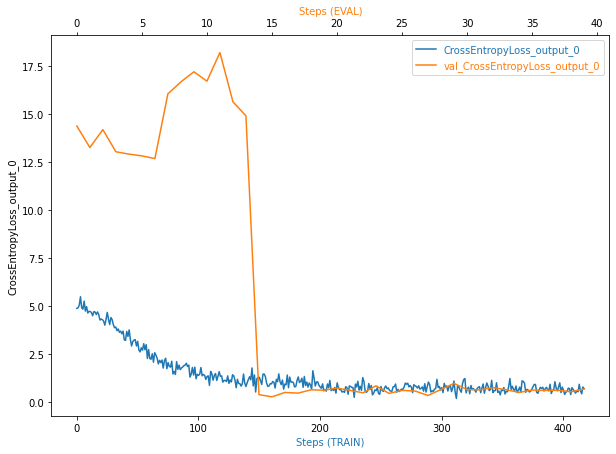

In [57]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

One of the things we need to put attention to here, is if the model is overfitting the training dataset. In this case it is not the case, but sometimes we observe that the loss in the training set keeps getting better and better, while the loss in the validation set starts to degrate. To counteract this issue, one thing that we have used here is **early stopping**: "*An optimization technique used to reduce overfitting without compromising on model accuracy. The main idea behind early stopping is to stop training before a model starts to overfit.*" [Educative.io](https://www.educative.io/answers/what-is-early-stopping)

#### Checking system utilization

In [58]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-401658568889/', 'ProfilingIntervalInMilliseconds': 500}
s3 path:s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/profiler-output


Profiler data from system is available


In [59]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-02-27 21:02:00.487 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:36 INFO metrics_reader_base.py:134] Getting 54 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


#### Display the Profiler Report

The profiler report will be saved in an S3 bucket. Below we can see how to get the path of the report, fetch it and display it.

In [60]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/rule-output


In [61]:
! aws s3 ls {rule_output_path} --recursive

2023-02-27 20:56:58     329709 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-27 20:56:57     171069 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-27 20:56:54        192 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-27 20:56:54        200 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-27 20:56:54        126 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-27 20:56:54        127 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-27 20:56:54        199 final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-outp

In [62]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-401658568889/final-training-job-2023-02-27-20-02-40-658/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-401658568889/final-training-job-2

In [63]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [92]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# # Uncomment this cell when retrieving a model already trained
# from sagemaker.pytorch import PyTorch
# estimator = PyTorch.attach("pytorch-training-230218-1626-002-89bdc10e")

In [64]:
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
predictor

---------!

#### Load and preprocess image to send to endpoint for prediction

Breed:  118.Pembroke_welsh_corgi


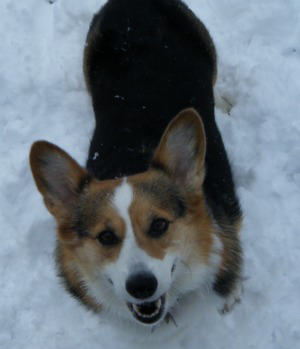

In [77]:
import os
import numpy as np
import random
from PIL import Image

data_dir = './dogImages/test'

# Select a random image :)
file_handles = os.listdir(data_dir)
random_breed = random.choice(file_handles)
file_handles_breed = os.listdir(f"{data_dir}/{random_breed}")
random_img = random.choice(file_handles_breed)

print("Breed: ", random_breed)
img = Image.open(f"{data_dir}/{random_breed}/{random_img}")
img

In [78]:
file_handles_breed

['Pembroke_welsh_corgi_07652.jpg',
 'Pembroke_welsh_corgi_07625.jpg',
 'Pembroke_welsh_corgi_07658.jpg',
 'Pembroke_welsh_corgi_07672.jpg',
 'Pembroke_welsh_corgi_07622.jpg',
 'Pembroke_welsh_corgi_07619.jpg',
 'Pembroke_welsh_corgi_07673.jpg']

In [79]:
np.asarray(img).shape

(349, 300, 3)

In [81]:
np.asarray(img).transpose().shape

(3, 300, 349)

In [82]:
np.expand_dims(np.asarray(img).transpose(), axis=0).shape

(1, 3, 300, 349)

To pass the image to the prediction, one alternative is to use a numpy array with dimensions: (Num. Images, Num. Channels, Image Width, Image Height)

#### Prediction

In [83]:
img_reshaped = np.expand_dims(np.asarray(img).transpose(), axis=0).astype(np.float32)
img_reshaped.shape

(1, 3, 300, 349)

In [84]:
response_raw = predictor.predict(img_reshaped)
print("Prediction result with no processing:")
print(np.argmax(response_raw[0]) + 1)
print("Breed: ", random_breed)

Prediction result with no processing:
83
Breed:  118.Pembroke_welsh_corgi


The prediction without processing of the image did not work. We got breed `83` and the actual breed is `118`.

In [85]:
import torchvision.transforms as transforms

def process_image(image):    
    img = image.convert('RGB')
    data_transform = transforms.Compose(
        [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )

    return data_transform(img)[:3,:,:].unsqueeze(0).numpy()

img_processed = process_image(img)

In [91]:
response = predictor.predict(img_processed)
print("Prediction result with processing:")
print(np.argmax(response[0]) + 1)
print("Breed: ", random_breed)

Prediction result with processing:
118
Breed:  118.Pembroke_welsh_corgi


It works! We got breed `118` from the endpoint :)